In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point

In [13]:
# load Zambia shapefile
zambia_fp = '/home/h99g576/zambia/Data/district.shp'
zambia_gdf = gpd.read_file(zambia_fp)
zambia_gdf.set_crs(epsg=4326, inplace=True)

# load survey data
df = pd.read_csv('/home/h99g576/zambia/Data/Charc.csv')

In [3]:
# filter for charcoal-producing households
charcoal_df = df[df['Charc'] == 1].copy()
charcoal_df.head()

,district,latitude,longitude,Charc,year
0,Mpongwe,-13.34090,28.340900,1.0,2016
3,Masaiti,-13.38757,28.694370,1.0,2016
8,Choma,-16.54721,26.958410,1.0,2016
11,Mungwi,-10.63736,32.153094,1.0,2016
15,Mkushi,-13.96311,29.429060,1.0,2016


In [4]:
# convert to geodataframe
charcoal_gdf = gpd.GeoDataFrame(
    charcoal_df,
    geometry=gpd.points_from_xy(charcoal_df.longitude, charcoal_df.latitude),
    crs='EPSG:4326'
)

/mnt/shared/moduleapps/EarthSci/Python-3.9.15-Mamba/lib/python3.9/site-packages/shapely/measurement.py:106: RuntimeWarning: invalid value encountered in bounds
  return lib.bounds(geometry_arr, out=out, **kwargs)


<Axes: >

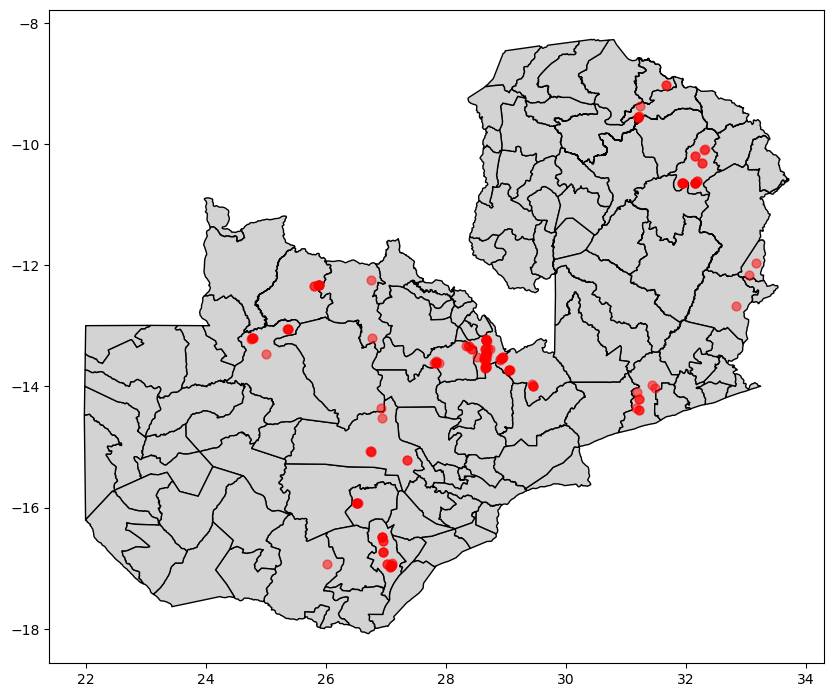

In [5]:
# plot
ax = zambia_gdf.plot(figsize=(10, 10), color='lightgray', edgecolor='black')
charcoal_gdf.plot(ax=ax, color='red', markersize=40, alpha=0.5)

In [6]:
zambia_gdf = zambia_gdf.rename(columns={'NAME_2': 'district'})
zambia_gdf['district'] = zambia_gdf['district'].str.strip().str.title()

In [7]:
# charcoal production counts by district
charcoal_counts = (
    df[df['Charc'] == 1]
    .groupby('district')
    .size()
    .reset_index(name='charcoal')
)

# merge with shapefile
zambia_merged = zambia_gdf.merge(charcoal_counts, on='district', how='left')
zambia_merged['charcoal'] = zambia_merged['charcoal'].fillna(0)

charcoal_production = zambia_merged[zambia_merged['charcoal'] > 0].copy()

In [8]:
# sort values
charcoal_production_sorted = charcoal_production.sort_values(by='charcoal', ascending=False)
charcoal_production_sorted.tail()

,GID_2,GID_0,COUNTRY,GID_1,NAME_1,NL_NAME_1,district,VARNAME_2,NL_NAME_2,TYPE_2,ENGTYPE_2,CC_2,HASC_2,geometry,charcoal
8,ZMB.1.9_2,ZMB,Zambia,ZMB.1_1,Central,NA,Mumbwa,NA,NA,District,District,NA,NA,"POLYGON ((27.19934 -14.34308, 27.20114 -14.345...",18.0
69,ZMB.7.7_2,ZMB,Zambia,ZMB.7_1,North-Western,NA,Mufumbwe,NA,NA,District,District,NA,NA,"POLYGON ((26.20064 -14.61559, 26.20018 -14.615...",14.0
31,ZMB.3.11_2,ZMB,Zambia,ZMB.3_1,Eastern,NA,Petauke,NA,NA,District,District,NA,NA,"POLYGON ((31.58771 -14.55068, 31.58746 -14.551...",11.0
80,ZMB.8.7_2,ZMB,Zambia,ZMB.8_1,Northern,NA,Mbala,NA,NA,District,District,NA,NA,"POLYGON ((31.36231 -8.59237, 31.36236 -8.59232...",9.0
28,ZMB.3.8_2,ZMB,Zambia,ZMB.3_1,Eastern,NA,Lundazi,NA,NA,District,District,NA,NA,"POLYGON ((33.29640 -12.54585, 33.29374 -12.546...",3.0


In [11]:
# get centroids
charcoal_production['centroid'] = charcoal_production.geometry.centroid

# create gdf of points
charcoal_points = gpd.GeoDataFrame(
    charcoal_production[['district', 'charcoal']],
    geometry=charcoal_production['centroid'],
    crs=charcoal_production.crs
)

charcoal_points.set_crs(epsg=4326, inplace=True)

,district,charcoal,geometry
8,Mumbwa,18.0,POINT (26.54441 -14.96744)
17,Masaiti,51.0,POINT (28.64977 -13.38752)
18,Mpongwe,25.0,POINT (27.74254 -13.58054)
28,Lundazi,3.0,POINT (33.23779 -12.39884)
31,Petauke,11.0,POINT (31.34360 -14.07375)
69,Mufumbwe,14.0,POINT (25.22959 -13.82679)
72,Solwezi,23.0,POINT (26.50521 -12.56086)
80,Mbala,9.0,POINT (31.42789 -8.96319)
83,Mungwi,34.0,POINT (31.73639 -9.89306)
87,Choma,26.0,POINT (26.98635 -16.76288)


In [14]:
# add buffers
charcoal_points_utm = charcoal_points.to_crs(epsg=32735)
zambia_gdf_utm = zambia_gdf.to_crs(epsg=32735)

# create 25 and 50 km buffers (in meters)
buffer_25km = charcoal_points_utm.buffer(25000)
buffer_50km = charcoal_points_utm.buffer(50000)

# convert buffers to geodataframes
buffer_25km_gdf = gpd.GeoDataFrame(geometry=buffer_25km, crs=charcoal_points_utm.crs)
buffer_50km_gdf = gpd.GeoDataFrame(geometry=buffer_50km, crs=charcoal_points_utm.crs)

In [21]:
fig, ax = plt.subplots(figsize=(12, 10))

# Base Zambia map (optional: gray all districts, or use only charcoal ones)
zambia_gdf_utm.plot(ax=ax, color='whitesmoke', edgecolor='gray')

# plot 50km buffer
buffer_50km_gdf.plot(ax=ax, color='orange', alpha=0.2, edgecolor='darkorange')

buffer_25km_gdf.plot(ax=ax, color='red', alpha=0.2, edgecolor='firebrick')

# Proportional charcoal points
charcoal_points_utm.plot(
    ax=ax,
    markersize=charcoal_points['charcoal'] * 20,  # adjust scale factor as needed
    color='firebrick',
    alpha=0.7,
    edgecolor='black',
    linewidth=0.5
)

# label districts
for idx, row in charcoal_points_utm.iterrows():
    ax.text(
        row.geometry.x,
        row.geometry.y,
        row['district'],
        fontsize=8,
        ha='center',
        va='center',
        color='black'
    )
    
ax.set_title('Charcoal Production by District (Proportional Points)', fontsize=16)
ax.set_axis_off()
plt.tight_layout()
plt.show()

ImportError: Cannot load backend 'Qt5Agg' which requires the 'qt' interactive framework, as 'headless' is currently running